# Tutorial: fitting a BL Lac broad-band SED using angpy and sherpa

In this tutorial we will show how to use `sherpa` to wrap `agnpy` functions to perform the fit of the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
import agnpy
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed

# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

### `sherpa` wrapper of `agnpy`
Now let us [follow the `sherpa` documentation](https://sherpa.readthedocs.io/en/latest/model_classes/usermodel.html) and define a model wrapping `agnpy`'s functions to compute the Synchrotron and Synchrotron Self Compton SEDs. We will assume a broken power-law electron distribution.

**NOTE:** for the parameters that vary over several orders of magnitude (i.e. normalisation and Lorentz factors of the electron distribution) it is better to provide to the fitting routine a "scaled" version of them (e.g. their log10), such that larger ranges might be covered with small parameters variation.

**NOTE:** the size of the blob $R_{\rm b}$ is constrained through the variability time scale, $t_{\rm var}$, and the Doppler factor, $\delta_{\rm D}$, via: $R_{\rm b} = (c t_{\rm var} \delta_{\rm D}) / (1 + z)$.

In [2]:
class AgnpySSC(model.RegriddableModel1D):
    """Wrapper of agnpy's synchrotron and SSC classes. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    def __init__(self, name="ssc"):

        # EED parameters
        self.log10_k_e = model.Parameter(name, "log10_k_e", -2.0, min=-20.0, max=10.0)
        self.p1 = model.Parameter(name, "p1", 2.1, min=-2.0, max=5.0)
        self.p2 = model.Parameter(name, "p2", 3.1, min=-2.0, max=5.0)
        self.log10_gamma_b = model.Parameter(name, "log10_gamma_b", 3, min=1, max=6)
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5, min=4, max=8)
        # source general parameters
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33, units="cm")
        # emission region parameters
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=40)
        self.log10_B = model.Parameter(name, "log10_B", -2, min=-4, max=2)
        self.t_var = model.Parameter(
            name, "t_var", 600, min=10, max=np.pi * 1e7, units="s"
        )

        model.RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p1,
                self.p2,
                self.log10_gamma_b,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.t_var,
            ),
        )

    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p1,
            p2,
            log10_gamma_b,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            t_var,
        ) = pars
        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        d_L *= u.cm
        R_b = c.to_value("cm s-1") * t_var * delta_D / (1 + z) * u.cm
        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
        )
        return sed_synch + sed_ssc

### Fitting with `sherpa`
Let us start here the procedure to fit with `sherpa`, first we read the data and then we pass them in a `Data1D` object provided by `sherpa`.     
We add an educated guess on systematic errors on the flux measurements in the different energy bands.       

In [3]:
# read the 1D data
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
sed_table = Table.read(sed_path)
x = sed_table["e_ref"].to("Hz", equivalencies=u.spectral())
y = sed_table["e2dnde"]
y_err_stat = sed_table["e2dnde_errn"]
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
y_err_syst = np.zeros(len(x))
# define energy ranges
nu_vhe = (100 * u.GeV).to("Hz", equivalencies=u.spectral())
nu_he = (0.1 * u.GeV).to("Hz", equivalencies=u.spectral())
nu_x_ray_max = (300 * u.keV).to("Hz", equivalencies=u.spectral())
nu_x_ray_min = (0.3 * u.keV).to("Hz", equivalencies=u.spectral())
vhe_gamma = x >= nu_vhe
he_gamma = (x >= nu_he) * (x < nu_vhe)
x_ray = (x >= nu_x_ray_min) * (x < nu_x_ray_max)
uv_to_radio = x < nu_x_ray_min
# declare systematics
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = y * y_err_syst
# define the data1D object containing it
sed = data.Data1D("sed", x, y, staterror=y_err_stat, syserror=y_err_syst)

Now we create an instance of the model wrapping the synchrotron and SSC functionalities we defined above.
Let us initialise all the blob parameters with the parameters provided in the paper [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract). Let us leave free to vary the parameters describing the electron distribution, the Doppler factor and the magnetic field.

In [4]:
# declare a model
agnpy_ssc = AgnpySSC()
# initialise parameters
# parameters from Table 4 and Figure 11 of Abdo 2011
R_b = 5.2 * 1e16 * u.cm
z = 0.0308
d_L = Distance(z=z).to("cm")
# - AGN parameters
agnpy_ssc.z = z
agnpy_ssc.z.freeze()
agnpy_ssc.d_L = d_L.cgs.value
agnpy_ssc.d_L.freeze()
# - blob parameters
agnpy_ssc.delta_D = 18
agnpy_ssc.log10_B = -1.3
agnpy_ssc.t_var = (1 * u.d).to_value("s")
agnpy_ssc.t_var.freeze()
# - EED
agnpy_ssc.log10_k_e = -7.9
agnpy_ssc.p1 = 2.02
agnpy_ssc.p2 = 3.43
agnpy_ssc.log10_gamma_b = 5
agnpy_ssc.log10_gamma_min = np.log10(500)
agnpy_ssc.log10_gamma_min.freeze()
agnpy_ssc.log10_gamma_max = np.log10(1e6)
agnpy_ssc.log10_gamma_max.freeze()

Now we define the `Fit` procedure choosing the statistics (chi2) and the minimisation method. We will fit only the data between $10^{11}\,{\rm Hz}$ and $10^{30}\,{\rm Hz}$, avoiding the lowest-energy radio data usually attributed to the extended jet emission.

In [5]:
# fit using the Levenberg-Marquardt optimiser
fitter = Fit(sed, agnpy_ssc, stat=Chi2(), method=LevMar())
min_x = 1e11 * u.Hz
max_x = 1e30 * u.Hz
sed.notice(min_x, max_x)

In [6]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("-- fit succesful?", results.succeeded)
print(results.format())

-- fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 2124.06
Final fit statistic   = 271.166 at function evaluation 43
Data points           = 86
Degrees of freedom    = 80
Probability [Q-value] = 1.28553e-22
Reduced statistic     = 3.38957
Change in statistic   = 1852.9
   ssc.log10_k_e   -7.89139     +/- 0.0696219   
   ssc.p1         2.05619      +/- 0.0230819   
   ssc.p2         3.54295      +/- 0.0518196   
   ssc.log10_gamma_b   4.99117      +/- 0.0227736   
   ssc.delta_D    19.7605      +/- 0.618354    
   ssc.log10_B    -1.32711     +/- 0.039422    
CPU times: user 13.8 s, sys: 5.12 s, total: 18.9 s
Wall time: 19.3 s


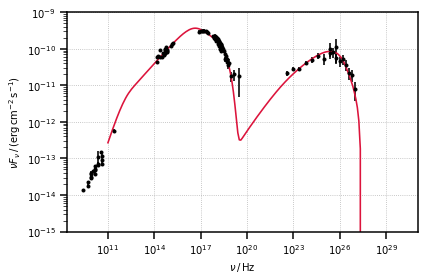

In [7]:
# plot the results!
load_mpl_rc()
x = np.logspace(np.log10(min_x.value), np.log10(max_x.value), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.get_error(), marker=".", ls="", color="k")
plot_sed(x, agnpy_ssc(x), ls="-", color="crimson")
plt.ylim([1e-15, 1e-9])
plt.show()